<a href="https://colab.research.google.com/github/omerhac/arc_challenge/blob/master/arc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import tensorflow as tf
import json
from google.cloud import storage
from matplotlib import pyplot as plt
from matplotlib import colors
AUTO = tf.data.experimental.AUTOTUNE

# Load data


In [0]:
## get paths
GCS_PATH = "gs://kds-d3cfb3d523ca35d2517017a78110126404d01fdea69417ce49950459"
training_filenames = tf.io.gfile.glob(GCS_PATH + "/training/*")
test_filenames = tf.io.gfile.glob(GCS_PATH + "/test/*")
eval_filenames = tf.io.gfile.glob(GCS_PATH + "/evaluation/*")

In [3]:
%%time
# create datasets with filenames
training_dataset = tf.data.Dataset.list_files(training_filenames)
eval_dataset = tf.data.Dataset.list_files(eval_filenames)
test_dataset = tf.data.Dataset.list_files(test_filenames)

CPU times: user 7.01 s, sys: 924 ms, total: 7.94 s
Wall time: 3min 59s


In [0]:
# load the jsons
def load_task(filename):
  task_json = tf.io.read_file(filename)
  return task_json

training_dataset = training_dataset.map(load_task)
eval_dataset = eval_dataset.map(load_task)
test_dataset = test_dataset.map(load_task)

training_dataset_numpy = tf.data.Dataset.as_numpy_iterator(training_dataset) # convert to numpy iterator
eval_dataset_numpy = tf.data.Dataset.as_numpy_iterator(eval_dataset)
test_dataset_numpy = tf.data.Dataset.as_numpy_iterator(test_dataset)


In [5]:
%%time
## create a numpy array of tasks (n_tasks, )
def array_from_jsons(jsons_numpy_iterator):
  """
    Create an array of task dictionaries from jsons numpy interator
  """

  tasks = []
  for task in jsons_numpy_iterator:
    tasks.append(json.loads(task))

  return np.stack(tasks)

## get numpy arrays of datasets
training_tasks = array_from_jsons(training_dataset_numpy)
eval_tasks = array_from_jsons(eval_dataset_numpy)
test_tasks = array_from_jsons(test_dataset_numpy)

CPU times: user 11 s, sys: 880 ms, total: 11.9 s
Wall time: 10min 4s


## Utility functions

In [0]:
def plot_board(board, ax, title=""):
  """
  Plot a board on a given axis
  """
  cmap = colors.ListedColormap(
      ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
        '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
  norm = colors.Normalize(vmin=0, vmax=9)
  
  ax.imshow(board, cmap=cmap, norm=norm)
  ax.grid(True,which='both',color='lightgrey', linewidth=0.5)    
  ax.set_yticks([x-0.5 for x in range(1+board.shape[0])])
  ax.set_xticks([x-0.5 for x in range(1+board.shape[1])])     
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  ax.set_title(title)

def plot_one(task, ax, i,train_or_test,input_or_output):
  """
  Plot one task on a given axis
  """
  cmap = colors.ListedColormap(
      ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
        '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
  norm = colors.Normalize(vmin=0, vmax=9)
  
  input_matrix = task[train_or_test][i][input_or_output]
  ax.imshow(input_matrix, cmap=cmap, norm=norm)
  ax.grid(True,which='both',color='lightgrey', linewidth=0.5)    
  ax.set_yticks([x-0.5 for x in range(1+len(input_matrix))])
  ax.set_xticks([x-0.5 for x in range(1+len(input_matrix[0]))])     
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  ax.set_title(train_or_test + ' '+input_or_output)
    

def plot_task(task):
    """
    Plots the first train and test pairs of a specified task,
    using same color scheme as the ARC app
    """    
    num_train = len(task['train'])
    fig, axs = plt.subplots(2, num_train, figsize=(3*num_train,3*2))
    for i in range(num_train):     
        plot_one(task, axs[0,i],i,'train','input')
        plot_one(task, axs[1,i],i,'train','output')        
    plt.tight_layout()
    plt.show()        
        
    num_test = len(task['test'])
    fig, axs = plt.subplots(2, num_test, figsize=(3*num_test,3*2))
    if num_test==1: 
        plot_one(task, axs[0],0,'test','input')
        plot_one(task, axs[1],0,'test','output')     
    else:
        for i in range(num_test):      
            plot_one(axs[0,i],i,'test','input')
            plot_one(axs[1,i],i,'test','output')  
    plt.tight_layout()
    plt.show() 
  

def plot_board_pairs(board_pairs, labels):
  """
  Plots the board pairs with their label as a title
  """

  fig, axs = plt.subplots(len(board_pairs), 2, figsize=(8, 3 * len(board_pairs)))
  
  for i, pair in enumerate(board_pairs):
    # plot a pair on a given axis
    plot_board(pair[0], axs[i, 0], title="anchor") 
    plot_board(pair[1], axs[i, 1], title=labels[i])
  
  plt.tight_layout()
  plt.show()

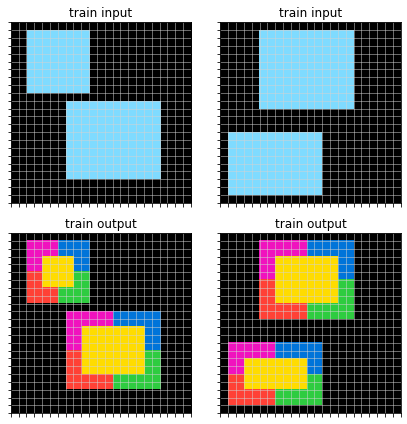

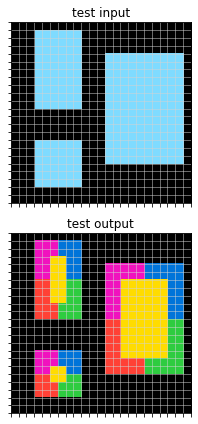

In [7]:
plot_task(eval_tasks[1])

# Check input / output shape distirbution

In [0]:
def get_dataset_shapes(dataset):
  """
  Returns dataset board shapes. 
  """

  shape_0 = []
  shape_1 = []
  
  # check every task
  for task in dataset:
    boards = get_task_boards(task) # get all boards
    shape_0 += [board.shape[0] for board in boards]
    shape_1 += [board.shape[1] for board in boards]
  
  return shape_0, shape_1

def get_task_boards(task, threshold_shape=(np.inf, np.inf), pad=None, test=False):
  """
  Get the training / testing boards of every example in a specific task. 

  Args: threshold_shape --> threshold shape for which 
  biggger samples won't be returned. 
  pad --> functional padding function to pad boards with (up tp threshold_size).
  test --> bool, whether a test task or not. for output of task example.
  """
  
  boards = []

  # train boards
  for example in task['train']:
    input_board = np.array(example['input'])
    output_board = np.array(example['output'])

    if((input_board.shape[0] < threshold_shape[0]) and (input_board.shape[1] < threshold_shape[1])):
      boards.append(pad(input_board, output_shape=threshold_shape) if pad else input_board) # check for padding func

    if((output_board.shape[0] < threshold_shape[0]) and (output_board.shape[1] < threshold_shape[1])):
      boards.append(pad(output_board, output_shape=threshold_shape) if pad else output_board) # check for padding func

  # test boards
  for example in task['test']:
    input_board = np.array(example['input'])

    if not test: # check if test example
      output_board = np.array(example['output'])
    
    # check whether the board is smaller then threshold shape
    if((input_board.shape[0] < threshold_shape[0]) and (input_board.shape[1] < threshold_shape[1])):
      boards.append(pad(input_board, output_shape=threshold_shape) if pad else input_board) # check for padding func

    if((output_board.shape[0] < threshold_shape[0]) and (output_board.shape[1] < threshold_shape[1]) and (not test)):
      boards.append(pad(output_board, output_shape=threshold_shape) if pad else output_board) # check for padding func

  return boards

def pad(mat, output_shape, padder=0):
  """
  Pad a matrix with padder up to output_shape. Insert matrix at upper left corner.
  
  Args:
  mat - np.array matrix of rank 2
  output_shape - tuple 
  padder - int
  """

  output_board = np.zeros(shape=output_shape) + padder # create output board and pad it

  # get input shape
  input_rows = mat.shape[0]
  input_cols = mat.shape[1]

  # if random=False, insert input matrix in upper left corner
  output_board[:input_rows, :input_cols] = mat
  return output_board

def random_pad(mat, output_shape, padder=0):
  """
  Pad a matrix with padder up to output_shape. Insert the matrix at a random location
  
  Args:
  mat - np.array matrix of rank 2
  output_shape - tuple 
  padder - int
  seed - int
  """

  output_board = np.zeros(shape=output_shape) + padder # create output board and pad it

  # get input shape
  input_rows = mat.shape[0]
  input_cols = mat.shape[1]

  # insert mat at a random loacation
  # get random location
  start_row = np.random.randint(output_shape[0] - input_rows)
  start_col = np.random.randint(output_shape[1] - input_cols)
  # insert
  output_board[start_row:start_row+input_rows, start_col:start_col+input_cols] = mat

  return output_board

In [0]:
train_shape_0, train_shape_1 = get_dataset_shapes(training_tasks)
eval_shape_0, eval_shape_1 = get_dataset_shapes(eval_tasks)

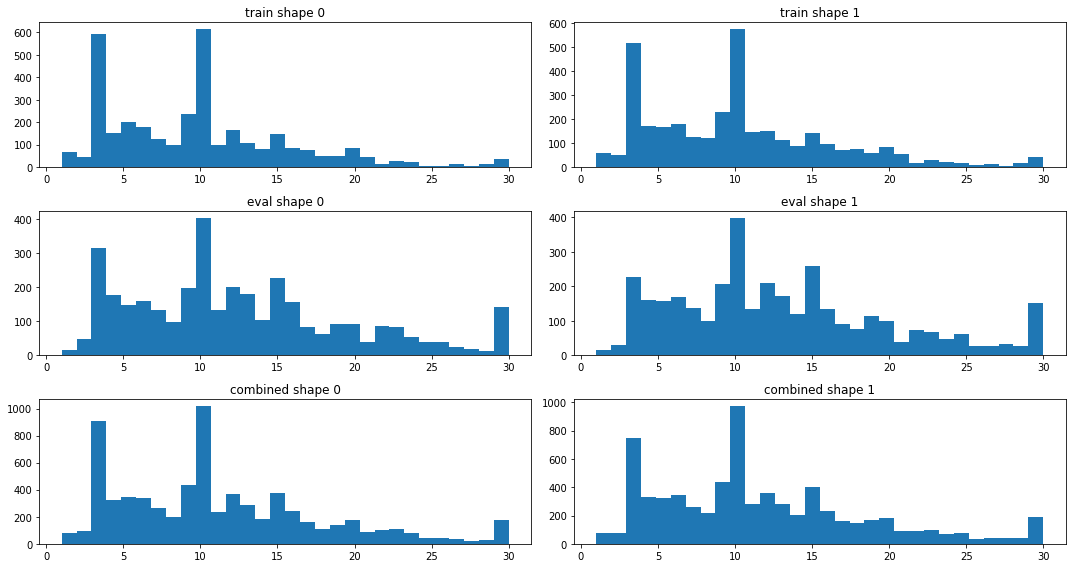

In [10]:
## plot
plt.figure(figsize=(15,8))
plt.subplot(3,2,1)
plt.hist(train_shape_0, bins=30)
plt.title("train shape 0")
plt.subplot(3,2,2)
plt.hist(train_shape_1, bins=30)
plt.title("train shape 1")
plt.subplot(3,2,3)
plt.hist(eval_shape_0, bins=30)
plt.title("eval shape 0")
plt.subplot(3,2,4)
plt.hist(eval_shape_1, bins=30)
plt.title("eval shape 1")
plt.subplot(3,2,5)
plt.hist(eval_shape_0 + train_shape_0, bins=30)
plt.title("combined shape 0")
plt.subplot(3,2,6)
plt.hist(eval_shape_1 + train_shape_1, bins=30)
plt.title("combined shape 1")
plt.tight_layout()
plt.show()

## Prepare data for learning pattern features

In [0]:
BOARD_SIZE = (15,15) # board upperbound size

# get all boards
training_boards = []
for task in training_tasks:
  training_boards += get_task_boards(task,threshold_shape=BOARD_SIZE, pad=pad)

eval_boards = []
for task in eval_tasks:
  eval_boards += get_task_boards(task,threshold_shape=BOARD_SIZE, pad=pad)

test_boards = []
for task in test_tasks:
  test_boards += get_task_boards(task,threshold_shape=BOARD_SIZE, pad=pad, test=True)

all_boards = training_boards+eval_boards+test_boards

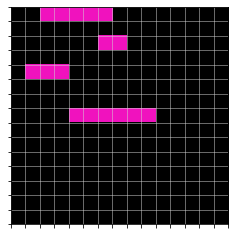

In [12]:
fig, ax = plt.subplots(1,1)
plot_board(test_boards[6], ax)

## Data augmentation

In [0]:
def get_rotated_views(board):
  """
  Turns a board 90 deg counter clockwise 3 times. Returns a list length 4 with all the rotated views including the original one.
  """

  rotates = [board]
  for i in range(3):
    board = np.rot90(board)
    rotates.append(board)
  
  return rotates

def get_rotated_data_pairs(rotated_views):
  """
  Creates all the possible pairs out of the rotated views tensor and labels them. If a1..a4 are rotated vies (A.C.W) of a1, returns labels according to:
   - (a1, a1) = 1 --> same board
   - (a1, a2) = 2 --> 90 a.c.w rotate
   - (a1, a3) = 3 --> 180 rotate
   - (a1, a4) = 4 --> 270 a.c.w rotate
   - ...
   - (a3, a4) = 2 --> 90 a.c.w rotate

  Args:
  rotated_views = a list of 4 rotated views of the board

  Returns:
  pairs: a list of tuples of boards
  labels: a list of labels matching each pair
  """

  # stopping rule
  if rotated_views == []:
    return [], []

  anchor = rotated_views[0]  # select board to compare with 
  pairs, labels = [], []
  label = 1 # init label

  # iterate over all remaining examples
  for view in rotated_views:
    pairs.append((anchor, view))
    labels.append(label)
    label += 1 # update label, views rotate a.c.w
  
  next_pairs, next_labels = get_rotated_data_pairs(rotated_views[1:]) # recursive call

  return pairs + next_pairs, labels + next_labels

def get_binary_board(board):
  """
  Returns a binary board. Every non 0 value becomes 1. 0 stays 0.
  """

  return (board != 0).astype('int32')


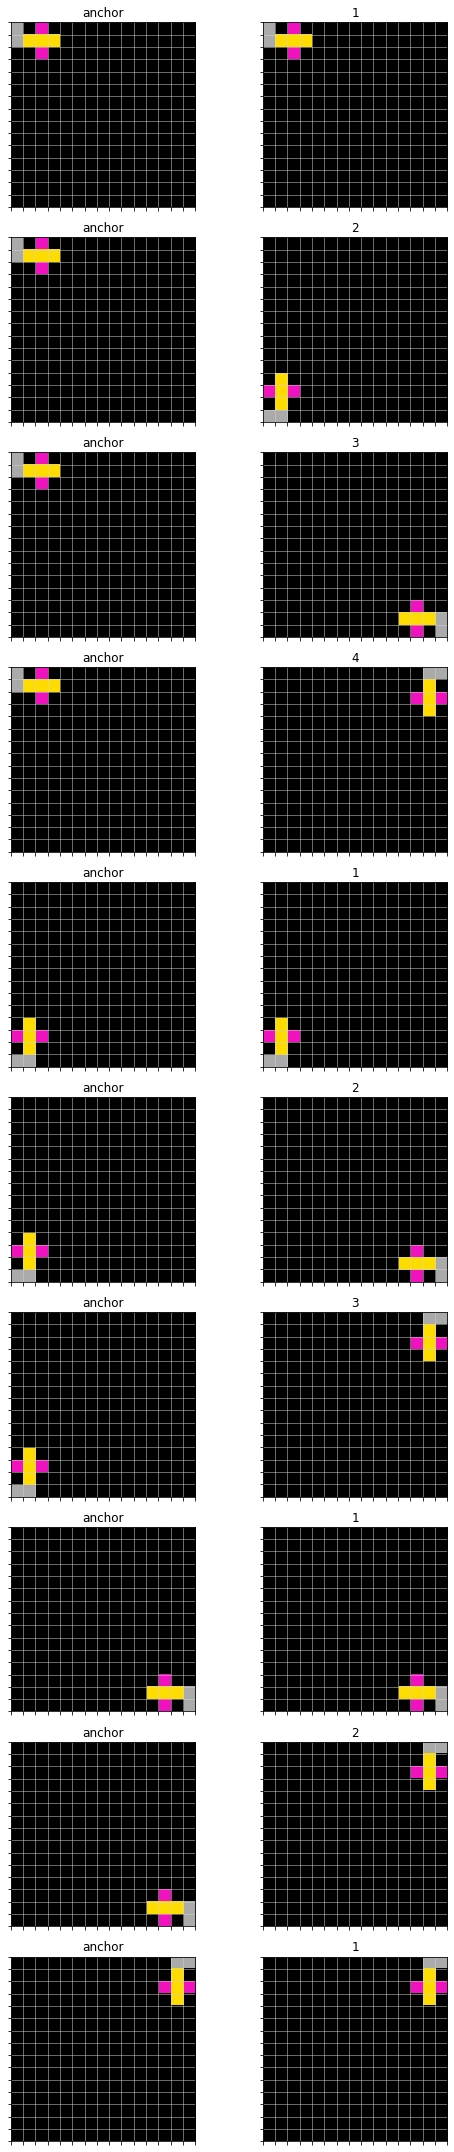

In [14]:
# test it
r = get_rotated_views(test_boards[7])
pairs, labels = get_rotated_data_pairs(r)
plot_board_pairs(pairs, labels)

# Siamese networks architecture

In [0]:
from tensorflow.keras.layers import Conv2D, Lambda, Dense, Flatten, MaxPool2D, Input

def get_siamese_networks_model(input_shape):
  """
  Creates siamese networks model. ref paper: https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf
  """

  # define input vectors
  input1 = Input(input_shape)
  input2 = Input(input_shape)

  # define model
  model = tf.keras.models.Sequential()

  # stack layers
  model.add(Conv2D(16, kernel_size=(3,3), activation='relu', input_shape=input_shape, padding='same'))
  model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'))
  model.add(MaxPool2D(pool_size=(2,2)))
  model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
  model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
  model.add(MaxPool2D(pool_size=(2,2)))
  model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))

  # flatten
  model.add(Flatten())

  # dense
  model.add(Dense(512, activation='sigmoid'))

  # compute the two feature vectors
  v1 = model(input1)
  v2 = model(input2)

  # compute L1 loss
  L1_Layer = Lambda(lambda tensors: tf.math.abs(tensors[0] - tensors[1]))
  L1_diff = L1_Layer([v1, v2])

  # compute probs
  probs = Dense(5, activation='softmax')(L1_diff)

  siamese_net = tf.keras.Model(inputs=[input1, input2], outputs=probs)
  siamese_net.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_accuracy'])
  return siamese_net

In [0]:
sn = get_siamese_networks_model([*BOARD_SIZE, 1])

In [17]:
sn.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 15, 15, 1)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 15, 15, 1)]  0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 512)          724416      input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 512)          0           sequential[1][0]             

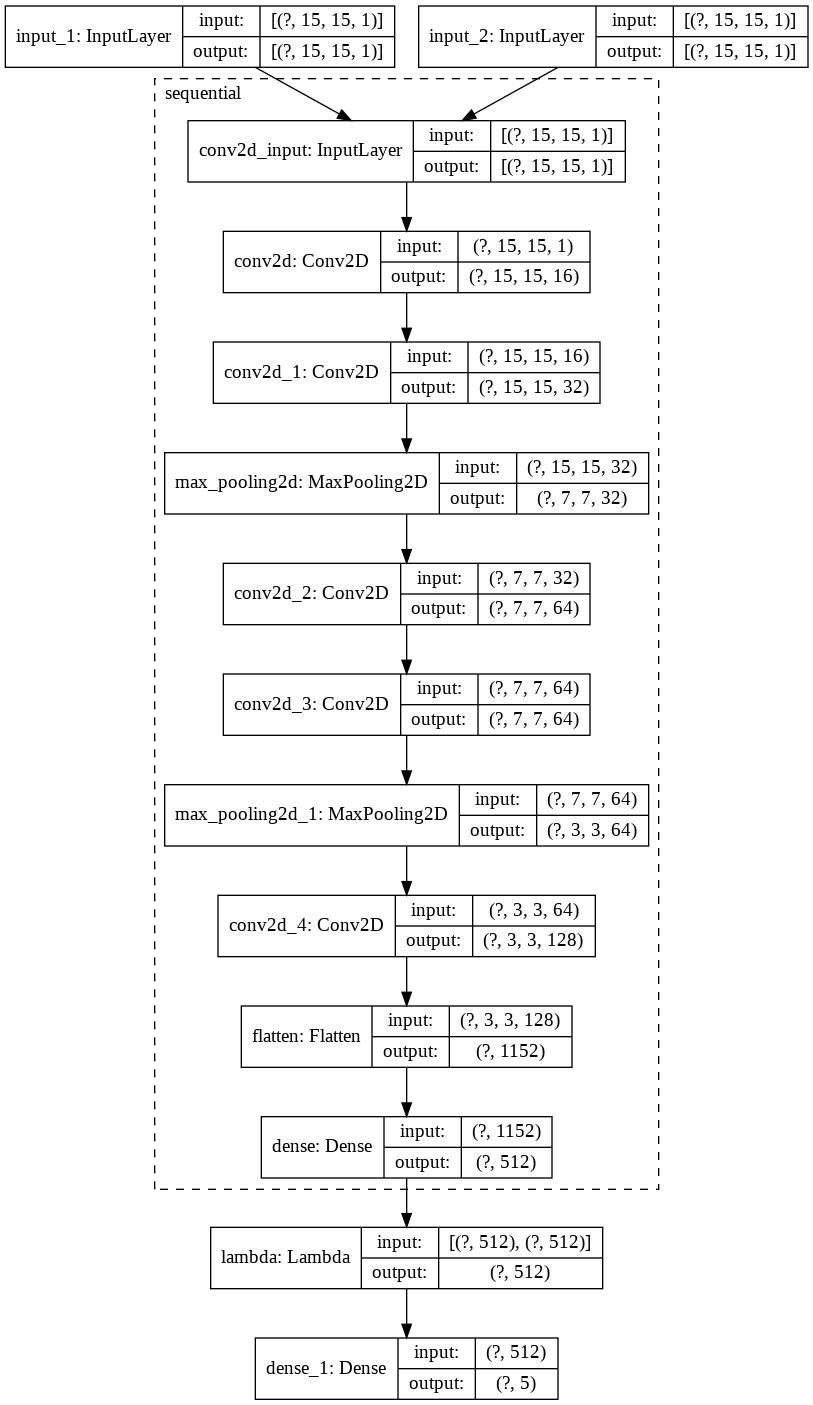

In [18]:
from tensorflow.keras.utils import plot_model
plot_model(sn, to_file='model.png', show_shapes=True, expand_nested=True)

# Create dataset

In [0]:
def get_all_pairs(board, all_boards):
  """
  Creates a list of pairs of data for the board. For all the possible rotates and a false match

  Args:
  board - np.array
  all_boards - all the other boards on the dataset not including this one

  Returns:
  a list of 5 tuples, 4 for the rotation part and 1 for a false match
  """

  rotated_views = get_rotated_views(board)
  rotated_pairs, rotated_labels = get_rotated_data_pairs(rotated_views)

  # create false match pair
  different_board = all_boards[np.random.randint(len(all_boards))] # generate random example
  false_label = 0

  return rotated_pairs + [(board, different_board)], rotated_labels + [false_label]
  

In [0]:
# binirize all boards
all_boards_binary = map(get_binary_board, all_boards) ### use all!!!

# create a list of all boards augmentation data
pair_list = []
label_list = []

# iterate over all boards
for i, board in enumerate(all_boards_binary):
  board_pairs, board_labels = get_all_pairs(board, all_boards[i:]) # augment example. use only boards from here onward
  pair_list += board_pairs
  label_list += board_labels

# zip to a single dataset
board_list_dataset = list(zip(pair_list, label_list))

In [56]:
%%time
BATCH_SIZE = 64

## create tf dataset
def get_dataset(list_dataset):
  """
  Returns a tf datset, shuffled, batched and repeated.
  """

  dataset = tf.data.Dataset.from_tensor_slices(list_dataset)
  #dataset = dataset.shuffle(2048)
  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.repeat()
  return dataset

boards_dataset = get_dataset(pair_list)
labels_dataset = get_dataset(label_list)


CPU times: user 48.3 s, sys: 32.8 ms, total: 48.3 s
Wall time: 48.3 s


In [61]:
_ = sn.fit(x=np.stack(pair_list), y=np.stack(label_list), epochs=10, steps_per_epoch=30, batch_size=BATCH_SIZE)

Epoch 1/10


ValueError: ignored